/home/ysweeney/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/ysweeney/anaconda2/lib/python2.7/site-packages/NeuroTools/__init__.py:125: DependencyWarning: ** interval ** package is not installed.
To have functions using interval please install the package.
website : http://pypi.python.org/pypi/interval/1.0.0

  warnings.warn(get_import_warning(name), DependencyWarning)


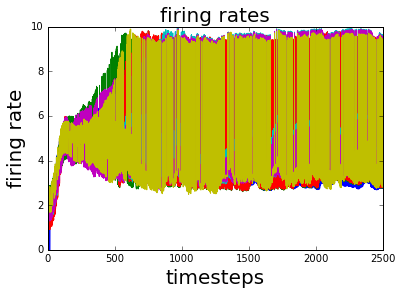

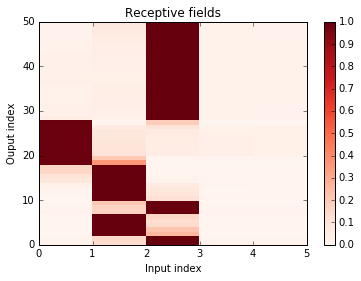

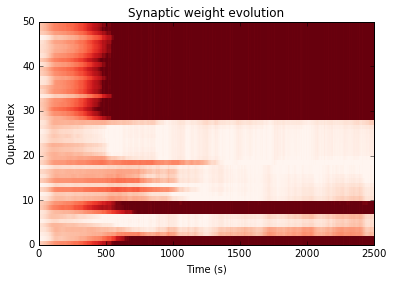

In [1]:
# this cell runs simulations of receptive field development in a feedforward network with diffusive BCM plasticity. It reproduces Fig 5C,E from the paper.

%matplotlib inline

import ff_network_functions_spatial_clean as FF_net

import numpy as np
import itertools

from matplotlib import pyplot as plt
from scipy import stats

from NeuroTools import stgen

FF_net.dt = .05
    
FF_net.N_inputs = 5 
FF_net.N_outputs = 50

FF_net.r_max=20.0

FF_net.N_orientations = 4

FF_net.ext_OU_noise = True
FF_net.ext_OU_tau = 50.0
FF_net.ext_OU_sigma = 0.0

x = np.zeros((FF_net.N_inputs,1))
y = np.zeros((FF_net.N_outputs,1))

H_0 = 2.5
FF_net.H = np.ones((FF_net.N_inputs))*H_0
FF_net.H_max = 10.0
FF_net.H_min = H_0

#np.random.seed(1111)

# controls the effective diffusive range
sigma_D = 0.05

x_coords, y_coords, euclid_distances, diffusion_distances = FF_net.generate_spatial_coordinates(FF_net.N_outputs,'uniform_exc_ordered_1D',0.01,'gaussian',sigma_D,True)
# making individual firing rate contribution larger
diffusion_distances+=np.identity(FF_net.N_outputs)*1

FF_net.W_max = 1.0
W = np.random.random((FF_net.N_outputs,FF_net.N_inputs))*FF_net.W_max*0.25

FF_net.alpha = 5e-8
FF_net.BCM_target = 5.0
FF_net.BCM_lambda=1.0 #Set < 1 for synaptic weight decay
 
FF_net.theta_BCM = np.ones((FF_net.N_outputs,1))*FF_net.BCM_target
FF_net.theta_BCM_dt = 10.0e-5

FF_net.HIP_target = np.ones((FF_net.N_outputs,1))*FF_net.BCM_target
FF_net.y_dt = FF_net.theta_BCM_dt
FF_net.HIP_dt = FF_net.alpha

T_static = 5000
T_plastic = 2500000
T_measure = 10000

FF_net.T_input_gen = min(100000,T_plastic/10)

T = T_static+T_plastic

stgen_drive = stgen.StGen()
FF_net.OU_drive = stgen_drive.OU_generator(1.,10.0,H_0,0.,0.,T).signal

pop_rate = []

FF_net.N_sample = min(FF_net.N_outputs,FF_net.N_inputs)
FF_net.sample_res = 1000

x,y,W,pop_rate_plastic,sample_rates_plastic,sample_weights,mean_incoming_weight,theta_BCM,sample_theta_BCM = FF_net.run_net_plastic_sliding_threshold(x,y,W,FF_net.theta_BCM,T_plastic,FF_net.N_sample,'random_dynamic',FF_net.N_orientations,0,False,diffusion_distances,True,'inner')

#For no spatial averaging, use below line instead
#x,W,pop_rate_plastic,sample_rates_plastic,sample_weights,mean_incoming_weight,theta_BCM,sample_theta_BCM,sample_inh_rates_plastic = rec_net.run_net_plastic_sliding_threshold(x,W,rec_net.theta_BCM,T_plastic,rec_net.N_sample,'random_dynamic',rec_net.N_orientations,0,False)

x_plastic = x.copy()
y_plastic = y.copy()
W_plastic = W.copy()
theta_BCM_plastic = theta_BCM.copy()

fig,axes = plt.subplots()
axes.plot(pop_rate_plastic,lw=5)
axes.plot(sample_rates_plastic)

axes.set_title('firing rates',fontsize=20)
axes.set_xlabel('timesteps',fontsize=20)
axes.set_ylabel('firing rate',fontsize=20)

fig,axes = plt.subplots()
plt.pcolor(W_plastic,cmap='Reds',vmin=0,vmax=FF_net.W_max)
axes.set_xlabel('Input index')
axes.set_ylabel('Ouput index')
axes.set_title('Receptive fields')
plt.colorbar()

fig,axes = plt.subplots()
axes.set_title('Synaptic weight evolution (input 2)')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Ouput index')
plt.pcolor(sample_weights[:,:,2].transpose(),cmap='Reds')